# Plots for case study

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import glob
import os

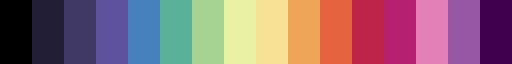

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='gray') #set missing (NaN) values to gray

discrete_mask_cmap

Define time period of case study

In [3]:
#Define time period
time1 = np.datetime64('2024-09-08T08:00')
time2 = np.datetime64('2024-09-08T14:00')

time_map1 = np.datetime64('2024-08-21T15:00')
time_map2 = np.datetime64('2024-08-21T15:10')

time_RHI = np.datetime64('2024-09-08T11:08:24.192') #start time for 278 azimuth at 11:08
#time_RHI = np.datetime64('2024-09-03T16:09')
az_RHI = 278.0
#az_RHI = 187.0
RHI_fname = '/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_rhi_2D.nc'
#RHI_fname= '/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/rhi/20240908/gridded_rhi_20240908_1108_278.0.nc' #start = 2024-09-08T11:08:24.192
#RHI_fname = '/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/rhi/20240903/gridded_rhi_20240903_1609_187.0.nc'

Define time period of other snapshot to plot

In [4]:
#time_map = np.datetime64('2024-09-02T05:50')
#time_map = np.datetime64('2024-09-01T21:40')
#time_map = np.datetime64('2024-09-02T18:00')
#time_map = np.datetime64('2024-09-21T18:50')
time_map = np.datetime64('2024-09-05T18:00')

QVP 1D data

In [5]:
# load data
#qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_1D/qvp_1D.nc')
qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_qvp_1D.nc')

#Find indices for start and end times
index1qvp = np.abs(pd.to_datetime(qvp.time) - time1).argmin()
index2qvp = np.abs(pd.to_datetime(qvp.time) - time2).argmin()

#Set missing data to NaN
qvp_DBZ = qvp.DBZ.where(qvp.DBZ != -9999, np.nan)

qvp

<xarray.Dataset> Size: 37MB
Dimensions:       (time: 5046, Z: 181)
Coordinates:
  * Z             (Z) float32 724B 0.0 100.0 200.0 ... 1.78e+04 1.79e+04 1.8e+04
    latitude      (time) float32 20kB 16.85 16.84 16.81 ... 13.16 13.16 13.16
    longitude     (time) float32 20kB -25.11 -25.11 -25.1 ... -59.41 -59.41
  * time          (time) datetime64[ns] 40kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables: (12/13)
    DBZ           (time, Z) float32 4MB nan nan nan ... -9.999e+03 -9.999e+03
    KDP           (time, Z) float32 4MB ...
    PHIDP         (time, Z) float32 4MB ...
    RAINRATE      (time, Z) float32 4MB ...
    RHOHV         (time, Z) float32 4MB ...
    SQI           (time, Z) float32 4MB ...
    ...            ...
    VEL           (time, Z) float32 4MB ...
    WIDTH         (time, Z) float32 4MB ...
    ZDR           (time, Z) float32 4MB ...
    grid_mapping  int32 4B ...
    start_time    (time) datetime64[ns] 40kB ...
    stop_time     (time) datetime64[ns] 40kB ...
Attributes: (12/14)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    creator_id:        https://orcid.org/0000-0002-0496-331X
    project:           PICCOLO, BOWTIE, ORCESTRA
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0

RHI data

In [6]:
#Load data
rhi = xr.open_dataset(RHI_fname)

#Find index
index_rhi = np.abs(pd.to_datetime(rhi.start_time) - time_RHI).argmin()
rhi_DBZ = rhi.DBZ[index_rhi, :, :]
rhi_ZDR = rhi.ZDR[index_rhi, :, :]
rhi_KDP = rhi.KDP[index_rhi, :, :]

#Set missing data to NaN
rhi_DBZ = rhi_DBZ.where(rhi_DBZ != -9999, np.nan)
rhi_ZDR = rhi_ZDR.where(rhi_ZDR != -9999, np.nan)
rhi_KDP = rhi_KDP.where(rhi_KDP != -9999, np.nan)

SEA-POL reflectivity

In [5]:
#Load data
#seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/gridded_rainrate/PICCOLO_gridded_rainrate_all.nc')
#seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_rainrate_2D.nc')
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_composite_2D.nc')

#Find indices
index_map1 = np.abs(pd.to_datetime(seapol.time) - time_map1).argmin()
index_map2 = np.abs(pd.to_datetime(seapol.time) - time_map2).argmin()
index_map = np.abs(pd.to_datetime(seapol.time) - time_map).argmin()

map1 = seapol.DBZ[index_map1,:,:]
map2 = seapol.DBZ[index_map2,:,:]
map = seapol.DBZ[index_map,:,:]

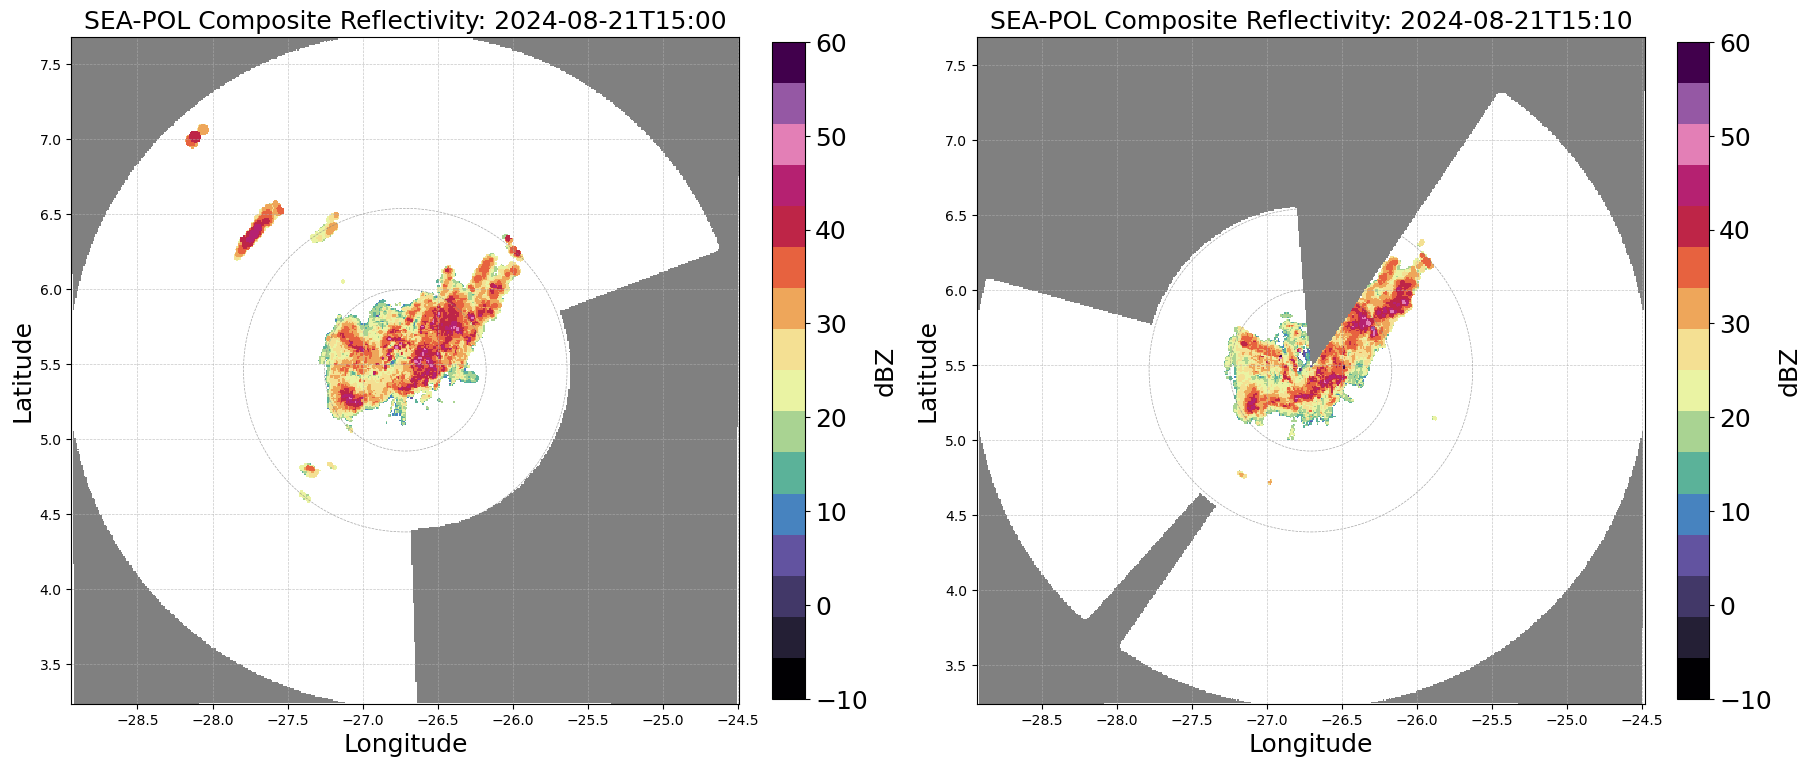

In [27]:
# Make plot
fig, axs = plt.subplots(1,2, figsize=(18, 8),layout="constrained")  # 1 row, 2 column

cax = axs[0].pcolormesh(map1.longitude, map1.latitude, map1, cmap=discrete_mask_cmap, vmin=-10, vmax=60,shading='auto')
axs[0].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[0], orientation='vertical',pad=0.02, shrink=0.83)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

axs[0].set_title('SEA-POL Composite Reflectivity: ' + str(time_map1),fontsize=18)    
axs[0].set_ylabel('Latitude', fontsize=18)
axs[0].set_xlabel('Longitude',fontsize=18)
#axs[0].set_xticks(np.linspace(-40,-36, 5))  # Adjust the number of ticks as needed
#axs[0].set_yticks(np.linspace(12, 16, 5))  # Adjust the number of ticks as needed
#axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=18)
#axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

cax = axs[1].pcolormesh(map2.longitude, map2.latitude, map2, cmap=discrete_mask_cmap, vmin=-10, vmax=60,shading='auto')
axs[1].set_aspect('equal',adjustable='box')

cbar = fig.colorbar(cax, ax=axs[1], orientation='vertical',pad=0.02, shrink=0.83)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

axs[1].set_title('SEA-POL Composite Reflectivity: ' + str(time_map2),fontsize=18)    
axs[1].set_ylabel('Latitude', fontsize=18)
axs[1].set_xlabel('Longitude',fontsize=18)
#axs[1].set_xticks(np.linspace(-40,-36, 5))  # Adjust the number of ticks as needed
#axs[1].set_yticks(np.linspace(12, 16, 5))  # Adjust the number of ticks as needed
#axs[1].set_xticklabels(axs[0].get_xticklabels(), fontsize=18)
#axs[1].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

# Add grid lines to the first subplot
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add grid lines to the second subplot
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add 120 km circle
axs[0].add_patch(plt.Circle((map1.longitude[245,245], map1.latitude[245,245]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
axs[1].add_patch(plt.Circle((map2.longitude[245,245], map2.latitude[245,245]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

# Add 60 km circle
axs[0].add_patch(plt.Circle((map1.longitude[245,245], map1.latitude[245,245]), 60/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
axs[1].add_patch(plt.Circle((map2.longitude[245,245], map2.latitude[245,245]), 60/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

# Add azimuth line
# Radar center (latitude and longitude)
center_lat = map1.latitude[245, 245]  # Replace with the radar's latitude
center_lon = map1.longitude[245, 245]  # Replace with the radar's longitude

# Azimuth in degrees
azimuth = 278

# Define the radius of the line (e.g., 120 km)
radius_km = 120
radius_deg = radius_km / 111.32  # Convert km to degrees (approximation)

# Calculate the endpoint of the line
end_lat = center_lat + radius_deg * np.cos(np.radians(azimuth))
end_lon = center_lon + radius_deg * np.sin(np.radians(azimuth))

# Draw the line on the first subplot
#axs[0].plot([center_lon, end_lon], [center_lat, end_lat], color='black', linestyle='-', linewidth=1.5)


/tmp/ipykernel_2453705/1405560054.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2453705/1405560054.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels(axs.get_yticklabels(), fontsize=18)


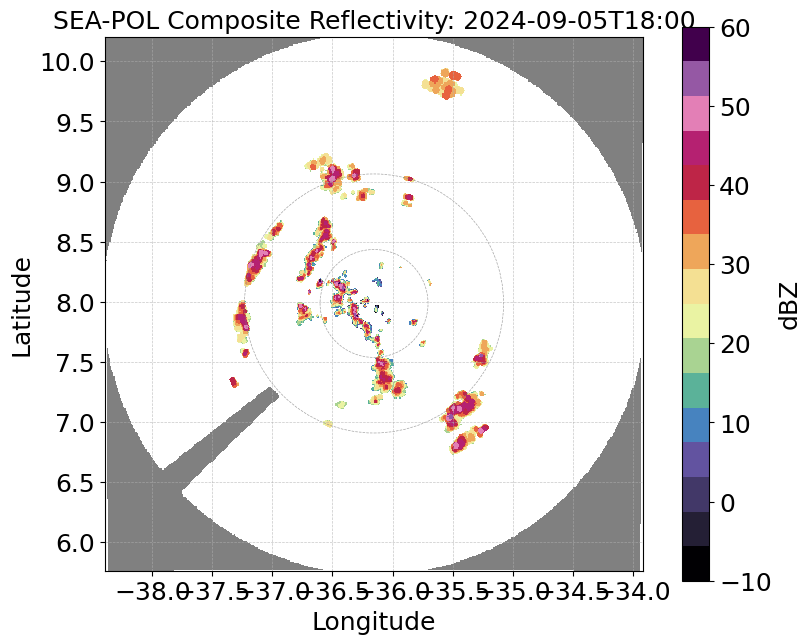

In [6]:
# Make plot
fig, axs = plt.subplots(figsize=(8, 8),layout="constrained")  

cax = axs.pcolormesh(map.longitude, map.latitude, map, cmap=discrete_mask_cmap, vmin=-10, vmax=60,shading='auto')
axs.set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs, orientation='vertical',pad=0.02, shrink=0.70)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

axs.set_title('SEA-POL Composite Reflectivity: ' + str(time_map),fontsize=18)    
axs.set_ylabel('Latitude', fontsize=18)
axs.set_xlabel('Longitude',fontsize=18)
#axs.set_xticks(np.linspace(-31,-27, 5))  # Adjust the number of ticks as needed
#axs.set_yticks(np.linspace(10, 14, 5))  # Adjust the number of ticks as needed
axs.set_xticklabels(axs.get_xticklabels(), fontsize=18)
axs.set_yticklabels(axs.get_yticklabels(), fontsize=18)

# Add grid lines to the first subplot
axs.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add 120 km circle
axs.add_patch(plt.Circle((map.longitude[245,245], map.latitude[245,245]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

# Add 50 km circle
axs.add_patch(plt.Circle((map.longitude[245,245], map.latitude[245,245]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))


SEA-POL average average low-level rain rate

In [10]:
#load data
#rain = xr.open_dataset('../../data/SEA-POL_gridded_rainrate_spatial_means.nc')
rain = xr.open_dataset('../../data/SEA-POL_4b_rainrate_2D_spatial_means.nc')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(rain.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(rain.time) - time2).argmin()

Disdrometer data

In [11]:
#load data
disdro = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Distrometer/QC/final/DSD_METEOR_merged.nc')

#Find indices for start and end times
index_start_disdro = np.where(pd.to_datetime(disdro.time) == time1)[0]
index_start_disdro = int(index_start_disdro[0])

index_end_disdro = np.where(pd.to_datetime(disdro.time) == time2)[0]
index_end_disdro = int(index_end_disdro[0])

# Smooth with a running mean, restrict to the time period of interest
disdro_p = disdro.rain_rate_qc[index_start_disdro:index_end_disdro+1].rolling(time=10, center=True).mean() # 10 minute running mean


# Make plot

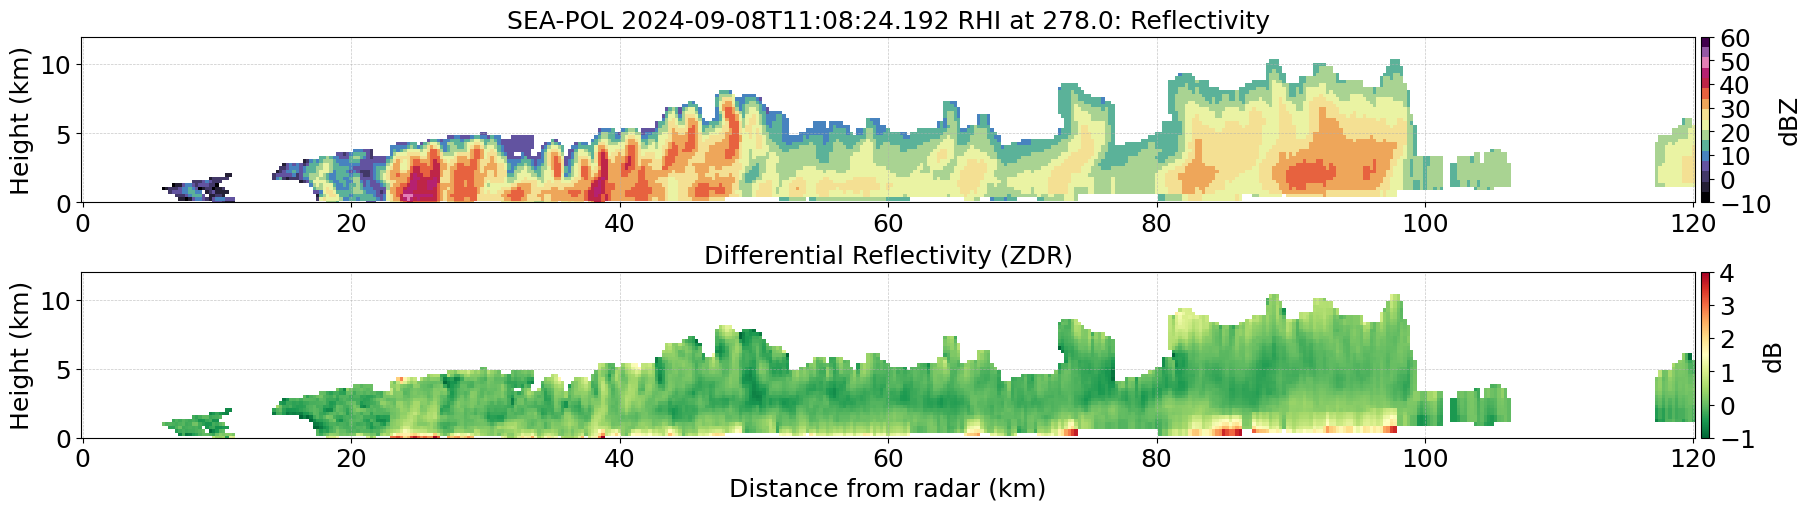

In [12]:
fig, axs = plt.subplots(2,1, figsize=(18, 5),layout="constrained")  # 2 rows, 1 column

#RHI dBZ
cax = axs[0].pcolormesh(rhi.R/1000, rhi.Z/1000, rhi_DBZ, cmap=discrete_cmap, vmin=-10, vmax=60,shading='auto')
cbar = fig.colorbar(cax, ax=axs[0], orientation='vertical',pad=-0.01)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

axs[0].set_ylim(0,12)
axs[0].set_title('SEA-POL '+str(time_RHI)+' RHI at '+str(az_RHI)+': Reflectivity',fontsize=18)   
axs[0].set_ylabel('Height (km)', fontsize=18)
#axs[0].set_xlabel('Distance from radar (km)',fontsize=18)
axs[0].tick_params(axis='both',labelsize=18)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

#RHI ZDR
cax1 = axs[1].pcolormesh(rhi.R/1000, rhi.Z/1000, rhi_ZDR, cmap='RdYlGn_r', vmin = -1, vmax = 4, shading='auto')
cbar1 = fig.colorbar(cax1, ax=axs[1], orientation='vertical',pad=-0.01)
cbar1.ax.tick_params(labelsize=18)
cbar1.set_ticks(np.linspace(-1,4,6))
#cbar1.ax.set_ylabel('Deg/km', fontsize=18)
cbar1.ax.set_ylabel('dB', fontsize=18)

axs[1].set_ylim(0,12)
#axs[1].set_title('Specific Differential Phase (KDP)',fontsize=18)
axs[1].set_title('Differential Reflectivity (ZDR)',fontsize=18)   
axs[1].set_ylabel('Height (km)', fontsize=18)
axs[1].set_xlabel('Distance from radar (km)',fontsize=18)
axs[1].tick_params(axis='both',labelsize=18)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


/tmp/ipykernel_215321/1830241364.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=18)
/tmp/ipykernel_215321/1830241364.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)
/tmp/ipykernel_215321/1830241364.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)


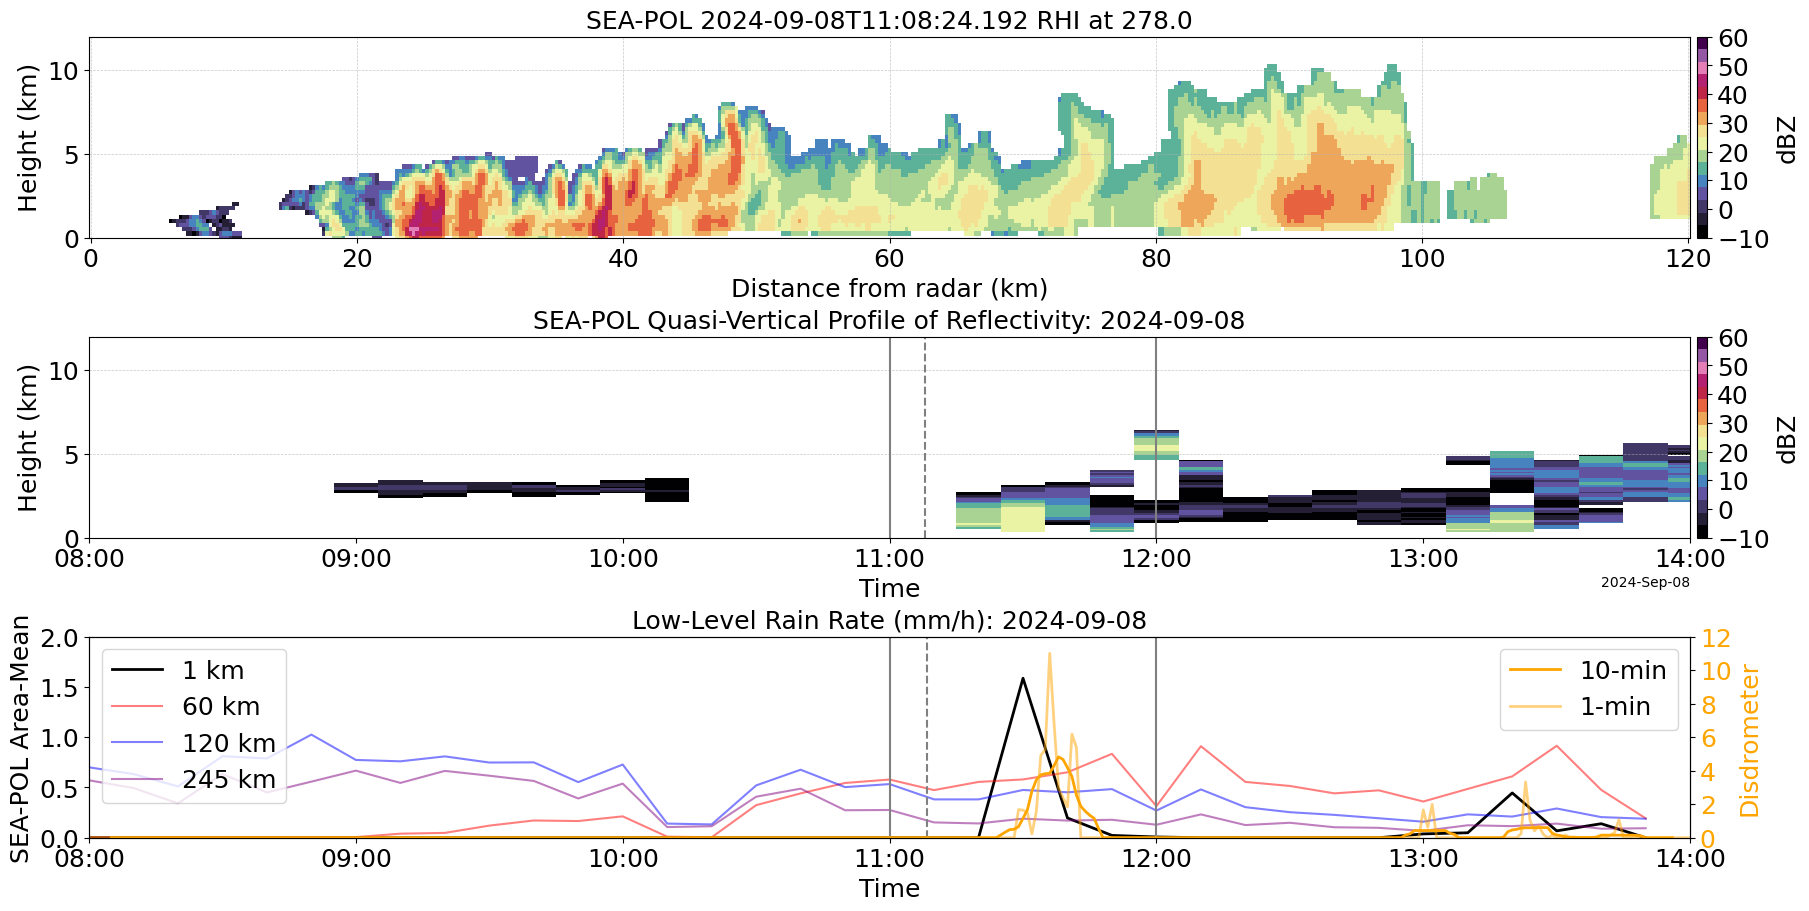

In [13]:
fig, axs = plt.subplots(3,1, figsize=(18, 9),layout="constrained")  # 3 rows, 1 column

#RHI
cax = axs[0].pcolormesh(rhi.R/1000, rhi.Z/1000, rhi_DBZ, cmap=discrete_cmap, vmin=-10, vmax=60,shading='auto')
cbar = fig.colorbar(cax, ax=axs[0], orientation='vertical',pad=-0.04)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

axs[0].set_ylim(0,12)
axs[0].set_title('SEA-POL '+str(time_RHI)+' RHI at '+str(az_RHI),fontsize=18)   
axs[0].set_ylabel('Height (km)', fontsize=18)
axs[0].set_xlabel('Distance from radar (km)',fontsize=18)
axs[0].tick_params(axis='both',labelsize=18)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


#QVP reflective time-height plot
#fig,ax = plt.subplots(figsize=(18,3))
cax = axs[1].pcolormesh(qvp.time[index1qvp:index2qvp+1], qvp.Z/1000, qvp_DBZ[index1qvp:index2qvp+1,:].transpose(), cmap=discrete_cmap, vmin=-10, vmax=60,shading='auto')
cbar = fig.colorbar(cax, ax=axs[1], orientation='vertical',pad=-0.04)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

#vertical lines at specific times
axs[1].axvline(x=pd.to_datetime('2024-09-08T11:00:00'), color='gray', linestyle='-')
axs[1].axvline(x=pd.to_datetime('2024-09-08T11:08:00'), color='gray', linestyle='--')
axs[1].axvline(x=pd.to_datetime('2024-09-08T12:00:00'), color='gray', linestyle='-')

axs[1].set_xlim(pd.to_datetime('2024-09-08T08:00:00'), pd.to_datetime('2024-09-08T14:00:00'))
axs[1].set_ylim(0, 12)

axs[1].set_title('SEA-POL Quasi-Vertical Profile of Reflectivity: 2024-09-08',fontsize=18)   
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))
axs[1].set_ylabel('Height (km)', fontsize=18)
axs[1].set_xlabel('Time',fontsize=18)
axs[1].tick_params(axis='both',labelsize=18)
axs[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

#Mean rain rate time series
#fig,ax = plt.subplots(figsize=(14,3),layout="constrained")
axs[2].plot(rain.time[index1:index2], rain.rain1_mean[index1:index2].values, color='black', label='1 km',linewidth=2)
axs[2].plot(rain.time[index1:index2], rain.rain60_mean[index1:index2].values, color='red', alpha=0.5, label='60 km')
axs[2].plot(rain.time[index1:index2], rain.rain120_mean[index1:index2].values, color='blue', alpha=0.5, label='120 km')
axs[2].plot(rain.time[index1:index2], rain.rain245_mean[index1:index2].values, color='purple', alpha=0.5, label='245 km')

#vertical lines at specific times
axs[2].axvline(x=pd.to_datetime(time_map1), color='gray', linestyle='-')
axs[2].axvline(x=pd.to_datetime(time_RHI), color='gray', linestyle='--')
axs[2].axvline(x=pd.to_datetime(time_map2), color='gray', linestyle='-')

axs[2].set_xlim(pd.to_datetime(time1), pd.to_datetime(time2))

axs[2].set_title('Low-Level Rain Rate (mm/h): 2024-09-08',fontsize=18)
axs[2].set_ylabel('SEA-POL Area-Mean', fontsize=18)
#axs[2].set_xlabel(f"Time (Start: {rain.time[index1].values})",fontsize=18)
axs[2].set_xlabel('Time',fontsize=18)
axs[2].set_ylim(0, 2)

axs[2].legend(loc='upper left', fontsize=18)

axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[2].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=18)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)

ax2 = axs[2].twinx()
ax2.plot(disdro.time[index_start_disdro:index_end_disdro+1], disdro_p.values, color='orange', linewidth=2,label='10-min')
ax2.plot(disdro.time[index_start_disdro:index_end_disdro+1], disdro.rain_rate_qc[index_start_disdro:index_end_disdro+1].values, color='orange', alpha=0.5, linewidth=2,label='1-min')
ax2.set_ylim(0,12)
ax2.set_ylabel('Disdrometer',color='orange',fontsize=18)
ax2.tick_params(axis='y',labelcolor='orange')
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)
ax2.legend(loc='upper right', fontsize=18)


Test cloudnet smoothing

In [14]:
#cloudnet
cloudnet = xr.open_dataset("ipns://latest.orcestra-campaign.org/products/METEOR/cloudnet.zarr", engine="zarr")
cloudnet

<xarray.Dataset> Size: 7GB
Dimensions:                 (time: 106200, height: 393)
Coordinates:
  * height                  (height) float32 2kB 120.3 135.3 ... 1.198e+04
  * time                    (time) datetime64[ns] 850kB 2024-08-17T00:00:15 ....
Data variables: (12/55)
    N_scaled                (time, height) float32 167MB ...
    Tw                      (time, height) float32 167MB ...
    Z                       (time, height) float32 167MB ...
    Z_bias                  (time) float32 425kB ...
    Z_error                 (time, height) float32 167MB ...
    Z_sensitivity           (time, height) float32 167MB ...
    ...                      ...
    rain_detected           (time) float64 850kB ...
    rainfall_rate           (time) float32 425kB ...
    target_classification   (time, height) float64 334MB ...
    v                       (time, height) float32 167MB ...
    v_sigma                 (time, height) float32 167MB ...
    width                   (time, height) float32 167MB ...
Attributes: (12/18)
    Conventions:         CF-1.8
    cloudnet_file_type:  der
    title:               Cloudnet droplet effective radius on RV Meteor durin...
    location:            RV Meteor
    year:                2024
    source:              RPG-Radiometer Physics RPG-FMCW-94\nLufft CHM15k\nEC...
    ...                  ...
    platform:            RV METEOR
    institution:         Leipzig Institute for Meteorology, Leipzig University
    instrument:          Cloudnet product based on cloud radar, ceilometer, m...
    creator_id:          ORCiD: 0000-0002-1164-3576
    keywords:            Cloudnet, effective radius, droplet
    featureType:         trajectoryProfile

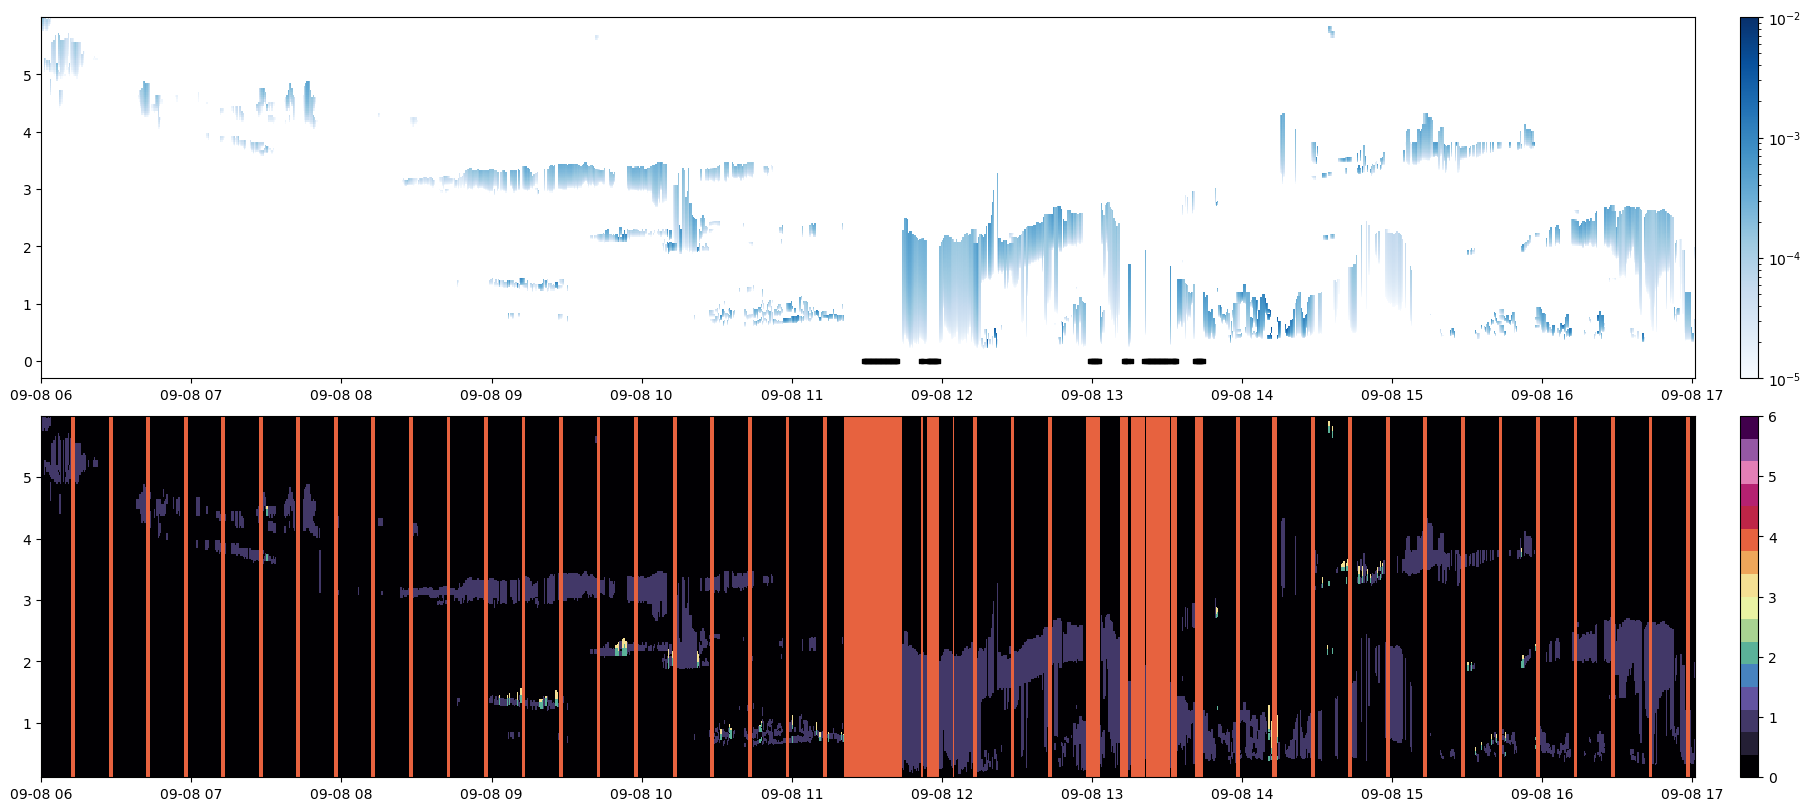

In [17]:
# plot cloudnet lwc
fig, axs = plt.subplots(2,1, figsize=(18, 8),layout="constrained")

lwc = cloudnet.lwc.sel(time=slice('2024-09-08 06:00', '2024-09-08 17:00'),height=slice(0,6000))
lwc_status = cloudnet.lwc_retrieval_status.sel(time=slice('2024-09-08 06:00', '2024-09-08 17:00'),height=slice(0,6000))
rain_flag = cloudnet.rain_detected.sel(time=slice('2024-09-08 06:00', '2024-09-08 17:00'))

rain_cmap=plt.get_cmap('Blues').copy()
rain_cmap.set_under(color='white') #set values below vmin to white


#interpolate over regular missing data (3 time steps of NaN in a row)

def interpolate_short_nan_runs(arr, max_nan_run=3):
    arr = arr.copy()
    isnan = np.isnan(arr)
    # Find runs of NaNs
    idx = np.arange(arr.size)
    nan_runs = []
    run_start = None
    for i, val in enumerate(isnan):
        if val and run_start is None:
            run_start = i
        elif not val and run_start is not None:
            if i - run_start <= max_nan_run:
                nan_runs.append((run_start, i))
            run_start = None
    if run_start is not None and arr.size - run_start <= max_nan_run:
        nan_runs.append((run_start, arr.size))
    # Interpolate over short runs
    for start, end in nan_runs:
        arr[start:end] = np.interp(idx[start:end], idx[~isnan], arr[~isnan])
    return arr

# Apply to each height level (axis=0)
lwc_interp = np.apply_along_axis(interpolate_short_nan_runs, 0, lwc.values, max_nan_run=3)
lwc = xr.DataArray(lwc_interp, coords=lwc.coords, dims=lwc.dims)

#

cax0=axs[0].pcolormesh(lwc.time, lwc.height/1000, lwc.transpose(), cmap=rain_cmap, norm=colors.LogNorm(vmin=0.00001,vmax=0.01),shading='auto')
cax1=axs[1].pcolormesh(lwc.time, lwc.height/1000, lwc_status.transpose(), cmap=discrete_mask_cmap, vmin=0, vmax=6, shading='auto')

# Add black dots for rain attenuation flag == 1
rain_flag_mask = (rain_flag.transpose() == 1)
#make array of zeros length of rain_flag_mask
zeros_array = np.zeros(rain_flag_mask.shape)
axs[0].scatter(lwc.time.values[rain_flag_mask],zeros_array[rain_flag_mask],color='black', s=10, marker='s',label='Rain Detected')

#add colorbars
cbar = fig.colorbar(cax0, ax=axs[0], orientation='vertical',pad=0.01)
cbar = fig.colorbar(cax1, ax=axs[1], orientation='vertical',pad=0.01)

